# Feature Selection and Predictive Modeling of E-Commerce Purchase Intent

## Group 24

**Members:**  
Andrew Liu, Audra Cornick, Haoxi Jiang, Nazia Chowdhury

**Date:**  
December 1, 2025


### Necessary R Libraries

In [22]:
library(tidyverse)
library(car)        # for VIF
library(glmnet)     # for LASSO
library(caret)      # for preprocessing
library(readr)
library(dplyr)
library(broom)
library(ggplot2)
library(pROC)
library(stringr)

# Introduction (321 words)

In the e-commerce industry, being able to predict whether a customer is likely to make a purchase is essential for designing effective recommendation systems, targeted marketing strategies, and personalized user experiences (Ding et al., 2015; Rajamma et al., 2009). Unlike in physical retail settings where sales associates can rely on experience, intuition, and real-time interactions to guide customers, online platforms must rely entirely on algorithmic decision-making (Moe, 2003). This creates a strong need for data-driven models that can identify which aspects of a user’s browsing behaviour are most informative for predicting the likelihood of a purchase.

Online shopping datasets often contain many behavioural, timing, and session-related variables, which can complicate traditional regression modeling due to multicollinearity and the inclusion of weak or redundant predictors. Logistic regression remains a standard, interpretable approach for predicting binary outcomes, while regularization techniques such as ridge regression can provide additional stability and improve predictive performance in the presence of multiple correlated variables.

**The guiding research question of this project is:**
 - Which combination of session-level, timing, and user/marketing features best predicts whether an online shopper completes a purchase, and how do model performance and interpretability differ between unpenalized logistic regression and ridge-penalized logistic regression?
 
Because the data come from naturally occurring online browsing sessions rather than a controlled experiment, it is not possible to draw causal conclusions about how specific variables influence purchasing behaviour. For this reason, our research question is intentionally focused on *prediction* and feature importance rather than estimating the effect of any individual variable.

This predictive approach mirrors existing work in e-commerce analytics, where retailers commonly use machine-learning–based recommendation systems, clickstream models, and regularized regression techniques to forecast customer actions and personalize online experiences (Chen, 2025; Narvekar & Banu, 2015; Satu & Islam, 2023). By comparing unpenalized logistic regression with ridge regression, we examine trade-offs between interpretability and predictive accuracy to determine the best models for predicting the probability of a customer making an online purchase. 


# Methods and Results 

## Data (100 words)

* read the data into R using reproducible code (i.e., from an open source and not a local directory in your server or computer)
include a citation of its source
* include any information you have about data collection (e.g., observational vs experimental)
* describe the variables as done in your Stage 1 Report.
* if (absolutely) needed, indicate which variables will be pre-selected (or dropped) and provide a clear justification of your selection.
* If your goal is prediction, you should keep all variables in the analysis and perform variable selection based on model performance.


In [3]:
data_url <- "https://raw.githubusercontent.com/audracornick/STAT301_Group24/main/online_shoppers_intention.csv"

OSPI <- read_csv(data_url)

head(OSPI)

Rows: 12330 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Month, VisitorType
dbl (14): Administrative, Administrative_Duration, Informational, Informatio...
lgl  (2): Weekend, Revenue

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>
0,0,0,0,1,0.000000,0.20000000,0.2000000,0,0,Feb,1,1,1,1,Returning_Visitor,FALSE,FALSE
0,0,0,0,2,64.000000,0.00000000,0.1000000,0,0,Feb,2,2,1,2,Returning_Visitor,FALSE,FALSE
0,0,0,0,1,0.000000,0.20000000,0.2000000,0,0,Feb,4,1,9,3,Returning_Visitor,FALSE,FALSE
0,0,0,0,2,2.666667,0.05000000,0.1400000,0,0,Feb,3,2,2,4,Returning_Visitor,FALSE,FALSE
0,0,0,0,10,627.500000,0.02000000,0.0500000,0,0,Feb,3,3,1,4,Returning_Visitor,TRUE,FALSE
0,0,0,0,19,154.216667,0.01578947,0.0245614,0,0,Feb,2,2,1,3,Returning_Visitor,FALSE,FALSE


In [4]:
OSPI_clean <- OSPI %>%
  filter(Region != 1) %>%
  mutate(
    Revenue = as.factor(Revenue),
    Month = as.factor(Month),
    VisitorType = as.factor(VisitorType),
    Weekend = as.factor(Weekend),
    SpecialDay = as.factor(SpecialDay),
    Browser = as.factor(Browser),
    TrafficType = as.factor(TrafficType),
    OperatingSystems = as.factor(OperatingSystems),
    Region         = as.factor(Region)
  ) %>%
  drop_na()

# Quick check
summary(OSPI_clean)

 Administrative   Administrative_Duration Informational    
 Min.   : 0.000   Min.   :   0.00         Min.   : 0.0000  
 1st Qu.: 0.000   1st Qu.:   0.00         1st Qu.: 0.0000  
 Median : 1.000   Median :  10.00         Median : 0.0000  
 Mean   : 2.343   Mean   :  81.56         Mean   : 0.4771  
 3rd Qu.: 4.000   3rd Qu.:  97.46         3rd Qu.: 0.0000  
 Max.   :27.000   Max.   :2156.17         Max.   :14.0000  
                                                           
 Informational_Duration ProductRelated   ProductRelated_Duration
 Min.   :   0.00        Min.   :  0.00   Min.   :    0.0        
 1st Qu.:   0.00        1st Qu.:  7.00   1st Qu.:  189.8        
 Median :   0.00        Median : 18.00   Median :  603.1        
 Mean   :  32.69        Mean   : 30.42   Mean   : 1143.2        
 3rd Qu.:   0.00        3rd Qu.: 37.00   3rd Qu.: 1448.9        
 Max.   :2252.03        Max.   :584.00   Max.   :24844.2        
                                                                


## EDA (250 words)

- Clean and wrangle your data into a tidy format (review Tidyverse's style guide Links to an external site.if needed)
- Include 2 effective and creative visualizations 
- explore the association of some potential explanatory variables with the response (use colours, point types, point size and/or faceting to include more variables)
- highlight potential problems (e.g., multicollinearity or outliers)
- You may utilize sub-plots as you did in Stage 1 Report.
- Use easily readable main/axis/legend titles, appropriately sized and without any underscores.
- Transform some variables if needed and include a clear explanation (e.g. log-transformation may be useful when outliers are present)
- Any summary tables that are relevant to your analysis (e.g., summarize number of observation in groups, indicate if NAs exist)
- Be sure not to print output that takes up a lot of screen space!
Your EDA must be comprehensive with high quality plots.

## Methods (356 words)

We analyzed the online shoppers dataset using a series of nested logistic regression models to assess which session and user characteristics are associated with a purchase (Revenue). Logistic regression was chosen because the response variable, Revenue, is binary, and the method is appropriate for modeling the relationship between multiple continuous and categorical predictors and the probability of a binary outcome.

Our modeling approach proceeded as follows:

1. **Data Cleaning and Variable Preparation:**

We removed sessions with missing or undefined regions and converted all categorical variables (e.g., Month, VisitorType, TrafficType, Browser, Weekend, SpecialDay) to factors. The response variable, Revenue, was also treated as a factor. This ensured that both GLM and regularized regression models could appropriately handle categorical predictors.

2. **Model Construction:**

We fitted four nested logistic regression models:

* **Null model:** intercept only, serving as a baseline.

* **Engagement model:** included `PageValues`, `ProductRelated`, and `ExitRates`, representing user interaction intensity.

* **Engagement + timing model:** added `Month`, `Weekend`, and `SpecialDay` to capture calendar and temporal effects.

* **Full model:** further added `VisitorType`, `TrafficType`, and `Browser` to account for user and marketing context.

The nested structure allowed us to evaluate incremental contributions of different variable sets via likelihood-ratio (deviance) tests.

3. **Model Selection and Justification:**

Deviance (likelihood-ratio) tests were used to compare nested models. At each step, a statistically significant reduction in deviance justified the inclusion of the additional variables. Variance inflation factors (VIFs) were calculated for the full model to check multicollinearity. All VIFs were well below common concern thresholds, indicating that coefficients could be interpreted reliably.

4. **Regularized Model Benchmark:**

In addition to the standard GLM, we fitted a ridge-penalized logistic regression using the same predictors. This approach provides coefficient shrinkage, helping to stabilize estimates in the presence of many categorical variables, though multicollinearity in our dataset was not severe.

5. **Training/Test Split and Model Assessment:**

The dataset was split into training (80%) and test (20%) sets. Performance metrics included classification accuracy, precision, recall, and F1 score on the test set. We also calculated predicted probabilities to generate ROC curves and assess overall discriminative ability via AUC. This ensured that model evaluation was relevant for prediction, while allowing the GLM coefficients to be interpreted for inference.

## Analysis & Results (483 words)

In [5]:
# Null model (intercept only)
model_null <- glm(
  Revenue ~ 1,
  data = OSPI_clean,
  family = "binomial"
)

# Model 1: engagement only
model_eng <- glm(
  Revenue ~ PageValues + ProductRelated + ExitRates,
  data = OSPI_clean,
  family = "binomial"
)

# Model 2: engagement + timing
model_eng_time <- glm(
  Revenue ~ PageValues + ProductRelated + ExitRates +
    Month + Weekend + SpecialDay,
  data = OSPI_clean,
  family = "binomial"
)

# Model 3: engagement + timing + context (your current full model)
model_full <- glm(
  Revenue ~ PageValues + ProductRelated + ExitRates +
    Month + Weekend + SpecialDay +
    VisitorType + TrafficType + Browser,
  data = OSPI_clean,
  family = "binomial"
)

anova(model_null, model_eng, model_eng_time, model_full, test = "Chisq")

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,7549,6398.498,NA,NA,NA
2,7546,4507.330,3,1891.16714,0.000000e+00
3,7531,4361.081,15,146.24931,1.338015e-23
4,7499,4311.934,32,49.14742,2.688674e-02


In [6]:
vif_values <- vif(model_full)
vif_values

,GVIF,Df,GVIF^(1/(2*Df))
PageValues,1.070396,1,1.034599
ProductRelated,1.177025,1,1.084908
ExitRates,1.193742,1,1.092585
Month,2.002097,9,1.039320
Weekend,1.067781,1,1.033335
SpecialDay,1.362298,5,1.031400
VisitorType,2.673435,2,1.278696
TrafficType,2.649057,18,1.027431
Browser,3.009321,12,1.046975


In [7]:
set.seed(123)

# Split into training (80%) and testing (20%)
train_index <- createDataPartition(OSPI_clean$Revenue, p = 0.8, list = FALSE)
train_data <- OSPI_clean[train_index, ]
test_data  <- OSPI_clean[-train_index, ]

# Create model matrices for glmnet (numeric inputs)
x_train <- model.matrix(
  Revenue ~ PageValues + ProductRelated + ExitRates +
    Month + Weekend + SpecialDay +
    VisitorType + TrafficType + Browser,
  data = train_data
)[, -1]

x_test <- model.matrix(
  Revenue ~ PageValues + ProductRelated + ExitRates +
    Month + Weekend + SpecialDay +
    VisitorType + TrafficType + Browser,
  data = test_data
)[, -1]

y_train <- as.numeric(train_data$Revenue) - 1
y_test  <- as.numeric(test_data$Revenue) - 1

In [9]:
glm_fit <- glm(
  Revenue ~ PageValues + ProductRelated + ExitRates +
    Month + Weekend + SpecialDay +
    VisitorType + TrafficType + Browser,
  data   = train_data,
  family = "binomial"
)

glm_tidy <- tidy(glm_fit, exponentiate = TRUE) 

# Rank predictors by p-value (smallest = "most significant")
ranked_by_p <- glm_tidy %>%
  arrange(p.value) %>%                   # ascending p-value
  mutate(
    rank = row_number()
  )

head(ranked_by_p)

term,estimate,std.error,statistic,p.value,rank
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
PageValues,1.085946e+00,0.0035465533,23.248447,1.474936e-119,1
ExitRates,1.795673e-07,2.2798335823,-6.813092,9.552302e-12,2
(Intercept),1.762824e-01,0.2935201542,-5.913284,3.353532e-09,3
ProductRelated,1.003417e+00,0.0008931052,3.818951,1.340205e-04,4
MonthDec,4.781367e-01,0.2652232072,-2.782028,5.402030e-03,5
TrafficType8,1.958099e+00,0.2548172890,2.637083,8.362246e-03,6


lambda.min (ridge) = 0.01732465 
lambda.1se  (ridge) = 0.04002219 


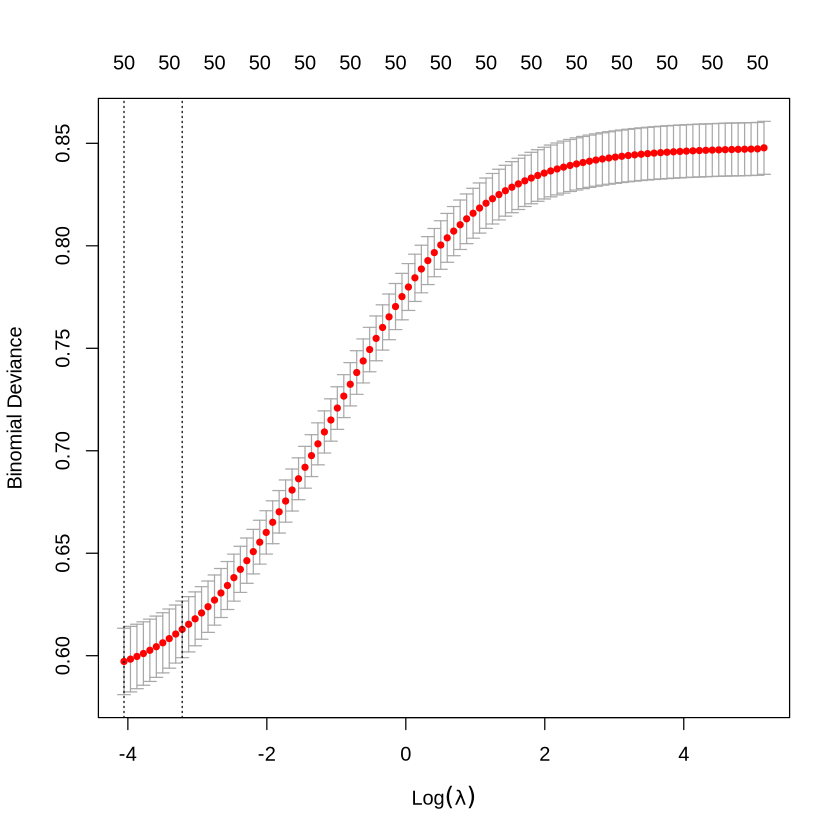

In [10]:
set.seed(123)

ridge_fit <- cv.glmnet(
  x_train, y_train,
  alpha = 0,               # 0 = RIDGE
  family = "binomial",
  type.measure = "deviance",
  nfolds = 10
)

# Inspect tuning
plot(ridge_fit)
cat("lambda.min (ridge) =", ridge_fit$lambda.min, "\n")
cat("lambda.1se  (ridge) =", ridge_fit$lambda.1se, "\n")

In [11]:
# Coefficients at lambda.min
coef(ridge_fit, s = "lambda.min")

51 x 1 sparse Matrix of class "dgCMatrix"
                                        s1
(Intercept)                  -1.9753509756
PageValues                    0.0604869571
ProductRelated                0.0038220601
ExitRates                    -9.3809766404
MonthDec                     -0.3974527841
MonthFeb                     -0.6193849488
MonthJul                      0.2030477833
MonthJune                    -0.2801638267
MonthMar                     -0.3159367367
MonthMay                     -0.1594793434
MonthNov                      0.4702275686
MonthOct                      0.2110842000
MonthSep                      0.1393848848
WeekendTRUE                   0.1297516255
SpecialDay0.2                 0.0834920197
SpecialDay0.4                -0.3299421980
SpecialDay0.6                 0.0230558080
SpecialDay0.8                -0.3766820889
SpecialDay1                  -0.5664998124
VisitorTypeOther             -0.2508794379
VisitorTypeReturning_Visitor -0.1902504374
TrafficType2

In [12]:
# Predicted probabilities on the test set
prob_test_glm <- predict(
  glm_fit,
  newdata = test_data,
  type   = "response"   # gives P(Revenue = 1 | X)
)

# Turn probabilities into class predictions with 0.5 cutoff
pred_test_glm <- ifelse(prob_test_glm > 0.5, 1, 0)

# Test accuracy
accuracy_glm <- mean(pred_test_glm == y_test)

prob_test_ridge <- predict(
  ridge_fit,
  newx = x_test,
  s = "lambda.min",
  type = "response"
)

pred_test_ridge <- ifelse(prob_test_ridge > 0.5, 1, 0)

# Test accuracy
accuracy_ridge <- mean(pred_test_ridge == y_test)

round(accuracy_glm, 3)
round(accuracy_ridge, 3)

[1] 0.89

[1] 0.885

In [13]:
# Confusion matrix for GLM logistic model
cm_glm <- confusionMatrix(
  data      = factor(pred_test_glm),
  reference = factor(y_test),
  positive  = "1"          # 1 = purchase
)

# Extract by-class metrics
m_glm <- cm_glm$byClass

metrics_glm <- c(
  precision = unname(m_glm["Pos Pred Value"]),
  recall    = unname(m_glm["Sensitivity"]),
  F1        = unname(m_glm["F1"])
)

cm <- confusionMatrix(
  data      = factor(pred_test_ridge),
  reference = factor(y_test),
  positive  = "1"          # 1 = purchase
)

# Extract the by-class metrics
m <- cm$byClass

metrics_ridge <- c(
  precision = unname(m["Pos Pred Value"]),
  recall    = unname(m["Sensitivity"]),
  F1        = unname(m["F1"])
)

signif(metrics_glm, 3)
signif(metrics_ridge, 3) 

precision    recall        F1 
    0.775     0.379     0.509

precision    recall        F1 
    0.812     0.304     0.442

Warning message in roc.default(y_test, prob_test_ridge, quiet = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”


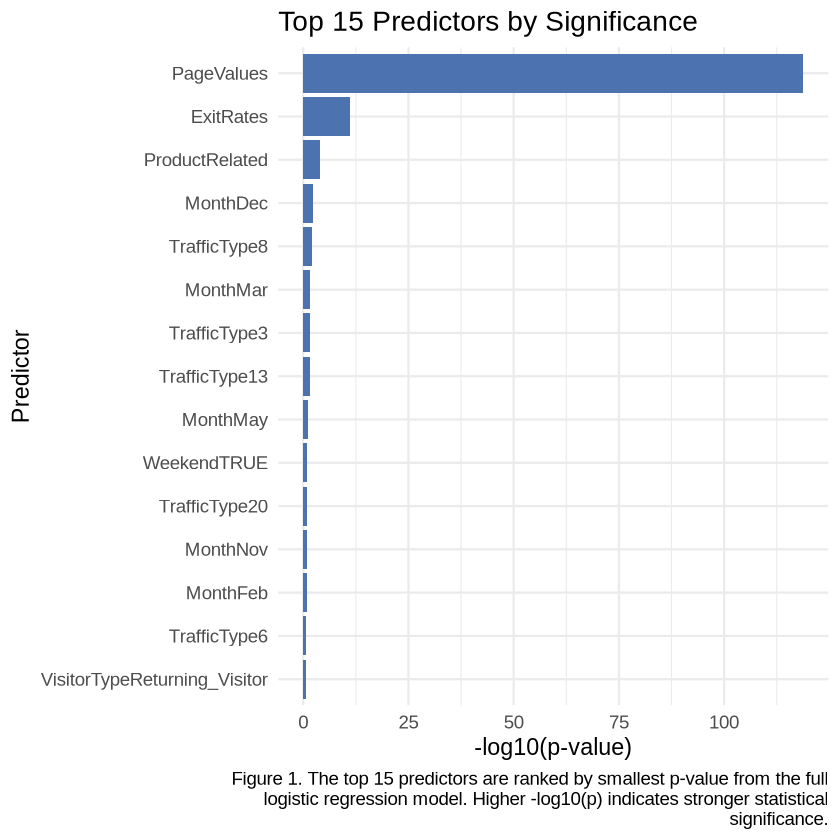

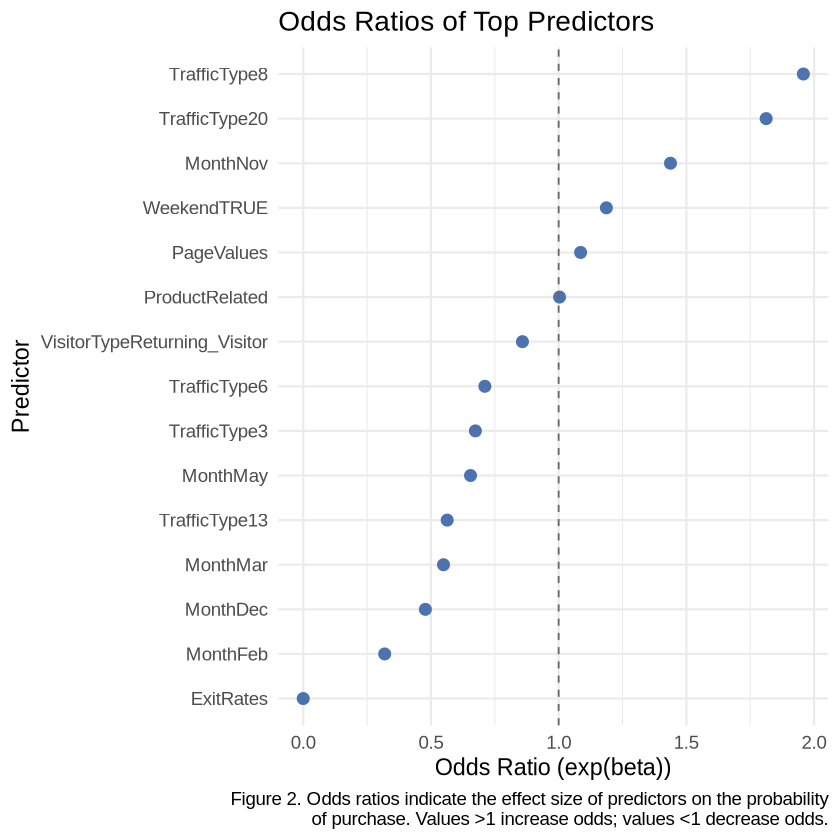

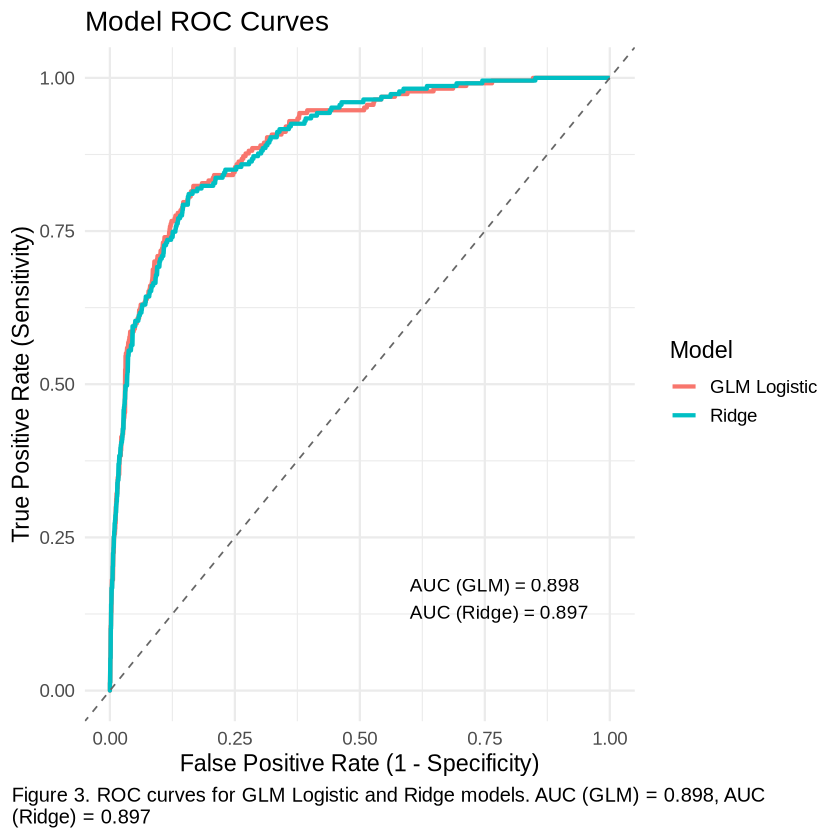

In [23]:
# Top 15 predictors by smallest p-value (exclude intercept)
top15_p <- ranked_by_p %>%
  filter(term != "(Intercept)") %>%
  arrange(p.value) %>%
  slice(1:15)

# Figure 1: P-plot -log10(p-value)
p_plot_top15 <- ggplot(top15_p, aes(x = reorder(term, -p.value), y = -log10(p.value))) +
  geom_col(fill = "#4C72B0") +
  coord_flip() +
  labs(
    title = "Top 15 Predictors by Significance",
    x = "Predictor",
    y = "-log10(p-value)",
    caption = str_wrap(
    "Figure 1. The top 15 predictors are ranked by smallest p-value from the full logistic regression model. Higher -log10(p) indicates stronger statistical significance.", 
    width = 80)) +
  theme(plot.caption.position = "plot",
        plot.caption = element_text(size = 12, hjust = 0)) +
  theme_minimal(base_size = 14)

# Compute ROC objects
roc_glm <- roc(y_test, prob_test_glm, quiet = TRUE)
roc_ridge <- roc(y_test, prob_test_ridge, quiet = TRUE)

# Create data frame for plotting
roc_df <- tibble(
  specificity = c(roc_glm$specificities, roc_ridge$specificities),
  sensitivity = c(roc_glm$sensitivities, roc_ridge$sensitivities),
  Model = rep(c("GLM Logistic", "Ridge"), 
              times = c(length(roc_glm$specificities), length(roc_ridge$specificities)))
)

# FIGURE 2: Odds ratios from the full logistic regression model
glm_coef_plot <- glm_tidy %>%
  filter(term != "(Intercept)" & term %in% top15_p$term) %>%
  ggplot(aes(x = reorder(term, estimate), y = estimate)) +
  geom_point(size = 3, color = "#4C72B0") +
  geom_hline(yintercept = 1, linetype = "dashed", color = "gray40") +
  coord_flip() +
  labs(
    title = "Odds Ratios of Top Predictors",
    x = "Predictor",
    y = "Odds Ratio (exp(beta))",
    caption = str_wrap(
    "Figure 2. Odds ratios indicate the effect size of predictors on the probability of purchase. Values >1 increase odds; values <1 decrease odds.", 
    width = 80)) +
  theme(plot.caption.position = "plot",
        plot.caption = element_text(size = 12, hjust = 0)) +
  theme_minimal(base_size = 14)

# Figure 3: ROC curve plot
roc_plot <- ggplot(roc_df, aes(x = 1 - specificity, y = sensitivity, color = Model)) +
  geom_line(size = 1.2) +
  geom_abline(linetype = "dashed", color = "gray40") +
  theme_minimal(base_size = 14) +
  labs(
    title = "Model ROC Curves",
    x = "False Positive Rate (1 - Specificity)",
    y = "True Positive Rate (Sensitivity)",
    color = "Model",
    caption = str_wrap(
    paste0("Figure 3. ROC curves for GLM Logistic and Ridge models. ",
           "AUC (GLM) = ", round(auc(roc_glm), 3), ", ",
           "AUC (Ridge) = ", round(auc(roc_ridge), 3)), 
    width = 80)) +
  theme(plot.caption.position = "plot",
        plot.caption = element_text(size = 12, hjust = 0)) +
  annotate("text", x = 0.6, y = 0.15,
           label = paste0("AUC (GLM) = ", round(auc(roc_glm), 3), "\n",
                          "AUC (Ridge) = ", round(auc(roc_ridge), 3)),
           hjust = 0, size = 4)

p_plot_top15
glm_coef_plot
roc_plot


### 1. Model Comparisons and Selection

Likelihood-ratio (deviance) tests comparing the four nested logistic regression models revealed that each step added statistically significant explanatory power:

- Moving from the **null model** (intercept only) to the **engagement model** reduced residual deviance by approximately 1891 on 3 degrees of freedom (p ≈ 0). This shows that engagement-related variables (PageValues, ProductRelated, ExitRates) explain a substantial portion of variation in purchase probability.  
- Adding **timing variables** (Month, Weekend, SpecialDay) further reduced deviance by about 146 on 15 df (p ≈ 1.3 × 10⁻²³), indicating that seasonality and special-day proximity significantly influence purchasing behavior.  
- Including **user/marketing variables** (VisitorType, TrafficType, Browser) produced a smaller but statistically significant reduction in deviance (~49 on 32 df, p ≈ 0.027).

Because all likelihood-ratio tests rejected simpler models in favor of more complex ones, we selected the **full model** for inference and prediction. Variance inflation factors (VIFs) for the full model were all below 1.3, indicating mild multicollinearity and stable, interpretable coefficients.

### 2. Interpretation of Key Predictors

Using the full logistic regression model:

- **PageValues** had a positive, highly significant coefficient, meaning that sessions with higher page value are more likely to result in a purchase.  
- **ProductRelated** also had a positive effect; users who view more product-related pages have higher odds of buying.  
- **ExitRates** was negative, indicating that sessions with pages where users frequently exit are less likely to convert.  
- **Timing variables** were jointly significant: month, weekend, and special-day effects meaningfully influenced purchase probability.  
- **User/marketing variables** had smaller but detectable effects: returning visitors had higher purchase odds, and certain traffic sources were more effective at driving purchases.

These patterns are summarized in **Figure 1**, showing the **top 15 predictors by p-value**, and **Figure 2**, which displays their **odds ratios** to illustrate the magnitude and direction of each effect.

### 3. Model Performance and Predictive Assessment

On the held-out test set:

- The **GLM logistic regression** achieved 0.89 classification accuracy.  
- The **ridge-penalized logistic model** achieved 0.88 accuracy, slightly lower.  
- Ridge regression had slightly higher **precision** (0.81 vs 0.78), meaning predicted purchases were more often correct, but **recall** was lower (0.30 vs 0.38), indicating more missed true purchases.  
- Consequently, the **F1 score** was higher for the GLM (0.51 vs 0.44), suggesting a better balance between precision and recall.

Because the project goal is to identify potential purchasers while maintaining reasonable precision, the **full GLM** is preferred. **Figure 3** shows ROC curves for both models with AUC values, highlighting the discriminative ability and predictive performance of each approach.

### 4. Summary of Key Findings

- Engagement metrics (PageValues, ProductRelated, ExitRates) are the strongest drivers of purchases.  
- Timing variables (Month, Weekend, SpecialDay) provide additional, statistically significant refinement.  
- User/marketing characteristics (VisitorType, TrafficType, Browser) offer smaller but detectable improvements.  
- Both GLM and ridge models achieve strong predictive performance; the GLM is chosen for **interpretability**, while ridge provides a benchmark for **regularization and stability**.

Overall, the results demonstrate that user engagement, temporal context, and visitor characteristics collectively explain the probability of purchase. 


# Discussion (500 words)

In this section, you’ll interpret and reflect on the results you obtained in the previous section with respect to the main question/goal of your project.

- Summarize what you found and the implications/impact of your findings
- If relevant, discuss whether your results were what you expected to find
- Discuss how your model could be improved
- Discuss future questions/research this study could lead to


# References

Chen, X. (2025). Consumer online shopping behavior prediction based on machine learning algorithm. *Procedia Computer Science, 262*, 1395–1401. https://doi.org/10.1016/j.procs.2025.05.187

Ding, A. W., Li, S., & Chatterjee, P. (2015). Learning user real-time intent for optimal dynamic web page transformation. *Information Systems Research, 26*(2), 339–359. https://doi.org/10.1287/isre.2015.0568

Moe, W. W. (2003). Buying, searching, or browsing: Differentiating between online shoppers using in-store navigational clickstream. *Journal of Consumer Psychology, 13*(1–2), 29–39. https://doi.org/10.1207/S15327663JCP13-1&2_03

Narvekar, M., & Banu, S. S. (2015). Predicting user's web navigation behavior using hybrid approach. *Procedia Computer Science, 45*, 3–12. https://doi.org/10.1016/j.procs.2015.03.073

Rajamma, R. K., Paswan, A. K., & Hossain, M. M. (2009). Why do shoppers abandon shopping cart? Perceived waiting time, risk, and transaction inconvenience. *Journal of Product & Brand Management*, 18(3), 188-197. https://doi.org/10.1108/10610420910957816

Sakar, C. O., Polat, S., Katircioglu, M., & Kastro, Y. (2019). Real-time prediction of online shoppers’ purchasing intention using multilayer perceptron and LSTM recurrent neural networks. *Neural Computing & Applications*. https://doi.org/10.24432/C5F88Q

Satu, M. S., & Islam, S. F. (2023). Modeling online customer purchase intention behavior applying different feature engineering and classification techniques. *Discover Artificial Intelligence, 3*(36). https://doi.org/10.1007/s44163-023-00086-0


